# 情绪对股票市场的影响

## 1.数据准备
风险偏好
事件

In [3]:
import sys
import os
import numpy as np
import cudf  #CUDA计算
import pandas as pd

sys.path.append('/home/ubuntu/notebook/Investor-Sentiment')
sys.path.append('/usr/local/stata17/utilities')
from pystata import config  #Stata
from statsmodels.regression.rolling import RollingOLS  #滚动回归
from statsmodels.regression.linear_model import OLS  #OLS回归
from pandarallel import pandarallel  #多线程groupby Apply

# 数据库
from utils.sql import DB
from loader.findata_loader import DownLoader
from loader.findata_loader import Loader

# 绘图
import matplotlib.pyplot as plt

# Stata
config.init('mp')

# ------------------------------数据集路径----------------------------------#
DATASETS_PATH = '/data/DataSets/investor_sentiment/'


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Colin's Stata
               Love U

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


### 1.1 下载和合并面板数据

In [4]:
# 数据集:个股K线面板数据,个股基本面数据
def load_data(): DownLoader(MAX_CORE=10).load_data()


load_data()

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


其他时间序列数据源

#### 指数盈利预测面板数据

In [5]:
data_loader = Loader()
data_loader.get_conidx_panel()

CON_YEAR        CON_OR        CON_NP  CON_EPS  \
trade_date ts_code                                                    
20131231   000002.SH      2013  2.150299e+09  1.996171e+08   0.6183   
           000010.SH      2013  1.616497e+09  1.803029e+08   0.7227   
           000015.SH      2013  9.223393e+08  1.402562e+08   0.7359   
           000016.SH      2013  1.095701e+09  1.190502e+08   0.7747   
           000067.SH      2013  1.304862e+08  7.875350e+06   0.5807   
...                        ...           ...           ...      ...   
20221028   399312.SZ      2022  3.583564e+09  3.023053e+08   1.1050   
           399313.SZ      2022  2.848629e+09  3.164494e+08   1.1574   
           399317.SZ      2022  7.321688e+09  5.934493e+08   0.7403   
           000985.SH      2022  7.224144e+09  5.840384e+08   0.7555   
           000688.SH      2022  6.009689e+07  7.351126e+06   1.0083   

                            CON_NA  CON_PB  CON_PS   CON_PE  CON_PEG  CON_ROE  \
trade_date ts_code                                                              
20131231   000002.SH  1.407965e+09  1.2913  0.8455   9.1078   0.5689    14.18   
           000010.SH  1.156060e+09  1.1894  0.8506   7.6264   0.5842    15.60   
           000015.SH  8.384264e+08  1.0141  0.9219   6.0624   0.5667    16.73   
           000016.SH  7.548906e+08  1.1679  0.8046   7.4054   0.5799    15.77   
           000067.SH  6.214941e+07  2.2588  1.0758  17.8255   0.9922    12.67   
...                            ...     ...     ...      ...      ...      ...   
20221028   399312.SZ  2.454648e+09  1.4467  0.9909  11.7465   0.7619    12.32   
           399313.SZ  2.754211e+09  0.9901  0.9572   8.6169   0.7773    11.49   
           399317.SZ  5.905421e+09  1.2950  1.0445  12.8868   0.7655    10.05   
           000985.SH  5.825681e+09  1.3191  1.0637  13.1574   0.7802    10.03   
           000688.SH  6.128843e+07  4.1037  4.1850  34.2135   0.9417    11.99   

                      CON_OR_YOY  CON_NP_YOY  CON_NPCGRATE_2Y  CON_PEI  
trade_date ts_code                                                      
20131231   000002.SH        9.89       18.25          16.0105  78.4365  
           000010.SH        8.21       13.78          13.0548  80.9011  
           000015.SH        5.53       11.24          10.6985  83.8420  
           000016.SH        7.24       13.37          12.7691  81.7573  
           000067.SH       12.46       16.76          17.9659  61.4964  
...                          ...         ...              ...      ...  
20221028   399312.SZ       15.04       15.51          15.4183  94.5570  
           399313.SZ       14.36       10.80          11.0863  94.4014  
           399317.SZ       10.82       15.55          16.8354  80.5216  
           000985.SH       10.96       15.11          16.8637  80.1858  
           000688.SH       43.95       46.41          36.3298  98.5569  

[43510 rows x 14 columns]

#### A股基本面面板数据

In [6]:
data_loader.get_ashare_panel()

share_return     total_mv
trade_date ts_code                             
20140102   000001.SZ       -0.1641  10025372.09
           000002.SZ       -0.4972   8799966.25
           000004.SZ        1.3734   99176.4638
           000005.SZ       -0.4000  227669.0681
           000006.SZ       -1.2164  657447.5874
...                            ...          ...
20221130   872374.BJ       -1.7259         <NA>
20221201   301290.SZ       -8.7349  485640.3232
           301311.SZ       12.7436     541440.0
           870199.BJ       -3.1447     149842.0
           872374.BJ        0.2066         <NA>

[7143120 rows x 2 columns]

#### 指数基本面面板数据

In [7]:
data_loader.get_index_panel()

shareindex_return      total_mv   total_share     pe  \
trade_date ts_code                                                          
20140102   000001.SH           -0.3115  1.816591e+13  3.233397e+12  10.71   
           000016.SH           -0.8688  8.764339e+12  1.536462e+12   8.35   
           000300.SH           -0.3454  1.724706e+13  2.880502e+12   9.79   
           000905.SH            0.4905  3.684081e+12  4.173544e+11  31.71   
           399001.SZ           -0.0911  1.809932e+12  1.431701e+11  16.19   
...                                ...           ...           ...    ...   
20221207   000016.SH           -0.5288  1.798471e+13  1.586560e+12  10.08   
           000300.SH           -0.2459  4.800432e+13  4.012892e+12  12.06   
           000905.SH           -0.1167  1.237585e+13  1.360448e+12  20.31   
           399001.SZ             0.175  2.251881e+13  1.292449e+12  25.40   
           399300.SZ              <NA>  4.800432e+13  4.012892e+12  12.06   

                      pe_ttm  
trade_date ts_code            
20140102   000001.SH    9.64  
           000016.SH    7.51  
           000300.SH    8.89  
           000905.SH   28.78  
           399001.SZ   14.84  
...                      ...  
20221207   000016.SH    9.57  
           000300.SH   11.55  
           000905.SH   23.74  
           399001.SZ   26.56  
           399300.SZ   11.55  

[13050 rows x 5 columns]

#### 时间序列数据

In [8]:
data_loader.get_time_series()

,img_neg,tex_neg,riskfree_return
trade_date,,,
20140102,0.0,0.0,0.015460
20140103,0.0,0.333333,0.015461
20140106,0.285714,0.142857,0.015481
20140107,0.0,0.333333,0.015489
20140108,0.333333,0.0,0.015506
...,...,...,...
20221125,<NA>,<NA>,0.006078
20221128,<NA>,<NA>,0.006069
20221129,<NA>,<NA>,0.006072


## 2.多群体视角下的情绪分析

先求出Profit,再用每日的变动解释,
先用000300.SH

#### 计算分析师偏离指标

In [9]:

# 计算每日实际净利润
def merge_profit(df_basic, df_profit):
    # 指数基本面板数据计算
    df_basic['trade_year'] = df_basic.index.levels[0] // 10000
    # 利润数据
    df_profit = df_profit.groupby(level=['trade_year', 'ts_code']).first()[['year_profit']]
    df_profit['year_profit_l1'] = df_profit['year_profit'].shift(1)
    # 合并
    return pd.merge(df_basic.reset_index(), df_profit.reset_index(), on=['trade_year', 'ts_code'])


# 计算衍生指标
def cal_der(df):
    df['year_profit_yoy'] = ((df['year_profit'] / df['year_profit_l1']) - 1) * 100
    return df


# 分析师指数预期对比指标
df_analyst = (
        cudf.merge(
                # 指数基本面+利润
                (cudf.from_pandas(cal_der(
                        merge_profit(
                                data_loader.get_index_panel().to_pandas().query("ts_code=='000300.SH'"),
                                pd.read_parquet('/data/DataSets/investor_sentiment/IDX_PANEL_PROFIT.parquet').query(
                                        "ts_code=='000300.SH'")
                        )
                ))),
                # 分析师一致预期
                data_loader.get_conidx_panel().reset_index(),
                on=['trade_date', 'ts_code'], sort=True
        )
).set_index(['trade_date', 'ts_code'])[['year_profit_yoy', 'CON_NP_YOY']].to_pandas()

# 计算分析师偏离
df_analyst['opt_profit_yoy'] = ((df_analyst['CON_NP_YOY'] - df_analyst['year_profit_yoy']) / df_analyst['year_profit_yoy'].abs()) * 100
df_analyst = df_analyst.reset_index()
df_analyst

# @formatter:off

,trade_date,ts_code,year_profit_yoy,CON_NP_YOY,opt_profit_yoy
0,20140102,000300.SH,7.550883,13.29,76.005909
1,20140103,000300.SH,7.550883,13.28,75.873474
2,20140106,000300.SH,7.550883,13.23,75.211300
3,20140107,000300.SH,7.550883,13.08,73.224778
4,20140108,000300.SH,7.550883,13.10,73.489647
...,...,...,...,...,...
2142,20221024,000300.SH,-12.537585,13.58,208.314320
2143,20221025,000300.SH,-12.537585,13.47,207.436958
2144,20221026,000300.SH,-12.537585,13.22,205.442954
2145,20221027,000300.SH,-12.537585,12.88,202.731108


#### 探索性回归分析

In [42]:
%pystata set graph_size  w 12in h 6in

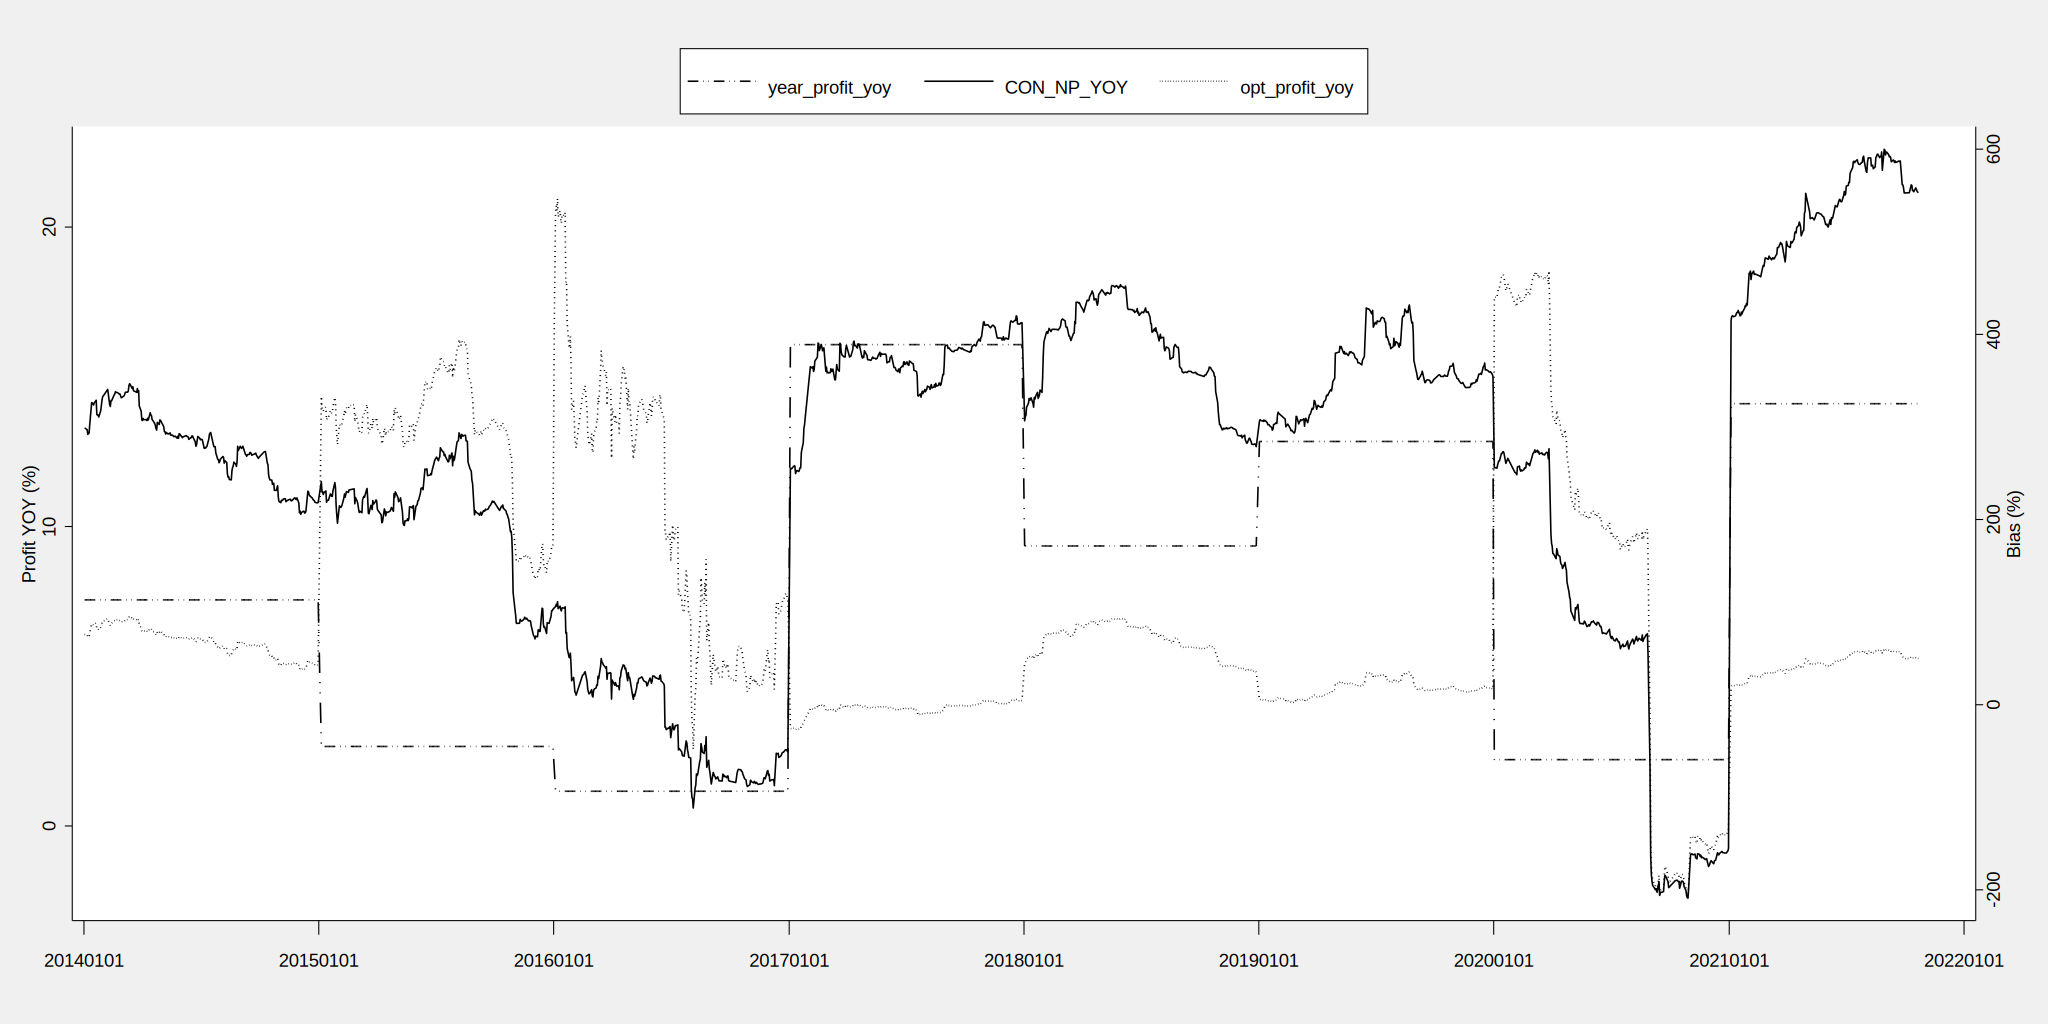

In [62]:
%%stata -d df_analyst -force -qui
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
tsset dt
twoway (tsline year_profit_yoy, lpattern(dash_dot_dot)) (tsline CON_NP_YOY, lpattern(solid)) (tsline opt_profit_yoy, yaxis(2) lpattern(tight_dot)) in 1/1900, ytitle(Profit YOY (%),axis(1)) ytitle(Bias (%),axis(2))  xtitle("") legend(rows(1) position(12)) scheme(sj) xsize(10)   ylabel(, nogrid)

## 3.截面效应分析

#### 3.1 计算面板数据的异质波动率

提取用于回归的数据

In [10]:
# @formatter:on
data_loader.get_cross_panel_reg()

AttributeError: 'Loader' object has no attribute 'get_cross_panel_reg'

In [ ]:
# 滚动OLS回归求异质波动率
def roll_idvol(df_code: pd.DataFrame, ols_window: int, var_ma: int) -> pd.DataFrame:
    try:
        # 估计参数
        model_ols = RollingOLS(endog=df_code[['Y']], exog=df_code[['CONST', 'X']], window=ols_window)
        df_para = model_ols.fit().params.rename(columns={'CONST': 'Alpha', 'X': 'Beta'})

        # 预测残差 已经对齐了
        df_con = pd.concat([df_code, df_para], axis=1, join='inner')
        df_con['Residual'] = df_con['Alpha'] + df_con['Beta'] * df_con['X'] - df_con['Y']

        # 计算月波动率
        df_con['Idvol'] = df_con['Residual'].rolling(var_ma).var(ddof=1)
        return df_con[['share_return', 'total_mv', 'Idvol']]
    except (IndexError, ValueError): return pd.DataFrame(columns=['trade_date', 'ts_code']).set_index(['trade_date', 'ts_code'])


# 分组计算
def cal_panel_ols():
    # 定义回归变量 CAPM回归: (rm-rf)=a+b*(RM-rf)
    df_panel['Y'] = df_panel['share_return'] - df_panel['riskfree_return']
    df_panel['CONST'] = 1  # 带截距项回归
    df_panel['X'] = df_panel['shareindex_return'] - df_panel['riskfree_return']

    # 多线程加速
    pandarallel.initialize(progress_bar=True)
    df_out = (df_panel.groupby(level=['ts_code'])[['share_return', 'total_mv', 'Y', 'CONST', 'X']]
              .parallel_apply(lambda x: roll_idvol(x, 5, 30)).droplevel(2)
              )

    # 保存
    df_out.to_parquet(f'{DATASETS_PATH}ASHARE_OLS_PANEL.parquet', engine='pyarrow', index=True)


# 计算滚动回归
if not os.path.exists(f'{DATASETS_PATH}ASHARE_OLS_PANEL.parquet'): cal_panel_ols()

# 加载滚动回归的面板数据集
df_ols_panel = (
        cudf.read_parquet(f'{DATASETS_PATH}ASHARE_OLS_PANEL.parquet').reset_index().set_index(['trade_date', 'ts_code']).sort_index()
        .rename(columns={'Idvol': 'idvol'})
)
df_ols_panel

### 3.2 面板数据分组

In [ ]:
# 参数阈值
QUANTILE = 0.5


# 面板数据分组
def group_ols_panel(df, group_col: str):
    """
    :param df:
    :param group_col:分组变量
    """
    # 分组
    df[f'{group_col}_split'] = df[group_col].groupby(level=['trade_date']).transform(lambda x: x.quantile(QUANTILE))
    df[f'{group_col}_group'] = np.where(df[group_col].to_pandas() >= df[f'{group_col}_split'].to_pandas(),
                                        f'{group_col}_high', f'{group_col}_low')
    # 重新设定分组索引
    df = df.reset_index().set_index(['trade_date', f'{group_col}_group', 'ts_code']).sort_index()

    # 求组中市值加权系数
    df[f'{group_col}_mv_ratio'] = df['total_mv'] / df.groupby(level=['trade_date', f'{group_col}_group'])['total_mv'].transform('sum')

    # 求组中回报
    df[f'{group_col}_vw_return'] = df[f'{group_col}_mv_ratio'] * df['share_return']
    df[f'{group_col}_group_return'] = (df.groupby(level=['trade_date', f'{group_col}_group'])[f'{group_col}_vw_return']
                                       .transform('sum'))

    # 重置索引
    return df.reset_index(f'{group_col}_group')


# 循环分组,最后处理成时间序列数据
def group_cols(df, columns: list):
    # 用于分组
    df_temp = df

    # 求组中市值加权回报
    for col in columns: df_temp = group_ols_panel(df_temp, col)

    # 筛选
    df_temp = df_temp[[i + '_group' for i in columns] + [i + '_group_return' for i in columns]]

    # 保留唯一的组合 2^N
    df_time_panel = (df_temp.reset_index().groupby(['trade_date'] + [i + '_group' for i in columns]).first())

    # 转为时间序列数据
    df_time = cudf.DataFrame()
    for col in columns: df_time = cudf.concat([df_time,
                                               df_time_panel.groupby(level=['trade_date', f'{col}_group']).first().reset_index()
                                              .pivot(index='trade_date', columns=f'{col}_group', values=f'{col}_group_return')],
                                              join="left", axis=1, sort=True)
    # 高减低
    # for col in columns: df_time[f'{col}_mid'] = df_time[f'{col}_high'] - df_time[f'{col}_low']

    return df_time


df_group_time = group_cols(df_ols_panel, ['total_mv', 'idvol'])
df_group_time

## 4. VAR模型分析

### 4.1 回归前数据处理

In [ ]:
# 增加用于回归的市场指数
df_time_join = (
        cudf.concat([get_time_series().drop(columns='riskfree_return'), df_group_time,
                     # 指数数据
                     cudf.from_pandas(get_index_panel()[['shareindex_return']].to_pandas().query("ts_code == '000001.SH'")
                                      .reset_index('ts_code', drop=True).rename(columns={'shareindex_return': 'idx_000001'})),
                     # 指数数据
                     cudf.from_pandas(get_index_panel()[['shareindex_return']].to_pandas().query("ts_code == '000300.SH'")
                                      .reset_index('ts_code', drop=True).rename(columns={'shareindex_return': 'idx_000300'})),
                     # 指数数据
                     cudf.from_pandas(get_index_panel()[['shareindex_return']].to_pandas().query("ts_code == '000016.SH'")
                                      .reset_index('ts_code', drop=True).rename(columns={'shareindex_return': 'idx_000016'})),
                     # 指数数据
                     cudf.from_pandas(get_index_panel()[['shareindex_return']].to_pandas().query("ts_code == '399300.SZ'")
                                      .reset_index('ts_code', drop=True).rename(columns={'shareindex_return': 'idx_399300'})),
                     ], sort=True, axis=1
                    ).dropna(axis=0).to_pandas()
)
df_time_join

In [ ]:
# 增加平方项
def add_square_column(df): return pd.concat([df, df.pow(2).add_suffix('_s')], axis=1)


# 增加日期虚拟变量
def add_dummy_column(df, column: str):
    df_weekday = pd.get_dummies(pd.to_datetime(df[column], format='%Y%m%d').dt.weekday, prefix='weekday', drop_first=True)
    df_month = pd.get_dummies(pd.to_datetime(df[column], format='%Y%m%d').dt.month, prefix='month', drop_first=True)
    return pd.concat([df, df_weekday, df_month], axis=1)


# 处理好的用于回归的数据
df_series_ols = add_dummy_column(add_square_column(df_time_join).reset_index(), 'trade_date')
df_series_ols
# @formatter:off

### 4.2 回归结果

In [ ]:
%%stata -d df_series_ols -force
//描述性统计
logout, save(Outputs/Table_Sum)  replace: ///
tabstat *_neg idx_* *_high *_low, s(N sd mean p50 min max ) f(%12.4f) c(s)

#### 4.2.1 主要股票市场

In [ ]:
%%stata -d df_series_ols -force -nogr
//时间设定
ge time = _n
tsset time
est clear

//VAR回归
foreach var in idx_000001 idx_000300 idx_000016 idx_399300    {
    rename(`var' `var'_s) (return return_s)

    eststo: qui var return img_neg return_s, lags(1/5) exog(month_* weekday_*)
    estadd local Month "Yes", replace
    estadd local Weekday "Yes", replace

    //绘图
    irf creat var, set(Outputs/`var'_img ,replace) step(5)
    irf graph oirf, impulse(img_neg) response(return) lstep(0) ustep(5) name(`var'_img,replace)  ///
    byopts(note("")) byopts(legend(off)) xtitle(, size(small) margin(zero)) ///
    ysc(r(-0.15,0.15)) yline(0) ylabel(#2) ytitle(return, size(small) margin(zero)) scheme(sj)

    rename(return return_s) (`var' `var'_s)
}

//输出
esttab , keep(return:L*.img_neg) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Month Weekday  r2_1 N, fmt(%3s %3s %12.4f %12.0f)) b(%12.4f) ///
title("Table1 Main Market") mtitle("000001.SH" "000300.SH" "000016.SH" "399300.SZ")  nogap

脉冲响应曲线

In [ ]:
%%stata
graph combine idx_000001_img idx_000016_img idx_000300_img idx_399300_img, ///
xcommon ycommon name(combine_img, replace) scheme(sj)

#### 4.2.2 套利限制

In [ ]:
%%stata -d df_series_ols -force
//时间设定
ge time = _n
tsset time
est clear

//VAR回归
foreach var in total_mv_high total_mv_low  idvol_high idvol_low {
    rename(`var' `var'_s) (return return_s)

    eststo: qui var return img_neg return_s, lags(1/5) exog(month_* weekday_*)
    estadd local Month "Yes", replace
    estadd local Weekday "Yes", replace

    rename(return return_s) (`var' `var'_s)
}

//输出
esttab , keep(return:L*.img_neg) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Month Weekday  r2_1 N, fmt(%3s %3s %12.4f %12.0f)) b(%12.4f) ///
title("Table1 Arbitrage Limit") mtitle("HIGH" "LOW" "HIGH" "LOW")  nogap ///
mgroups("Market Value" "Idiosyncratic Volatility", pattern(1 0 1 0) ) showtabs

## 5. 按照观测窗口构造投资策略(暂时不做)

In [ ]:
def cal_return(df, ma):
    df[f'img_neg_m{ma}'] = (df['img_neg'].rolling(ma).mean())

    # 历史均值K
    df['sell_signal'] = df['img_neg'] >= df[f'img_neg_m{ma}']
    df['sell_signal'] = df['sell_signal'].shift(1)

    # 高于均值投资
    df['img_return'] = np.where(df['sell_signal'], -1*(df['sell_signal']*df['HIGH']), df['shareindex_return'])

    # 去掉空行
    df.dropna(axis=0, inplace=True)

    # 换算
    df['mv_shareindex'] = ((df['shareindex_return'] + 100)/100)
    df['mv_img'] = ((df['img_return'] + 100)/100)
    df['mv_shareindex'] = df['mv_shareindex'].cumprod(axis=0)
    df['mv_img'] = df['mv_img'].cumprod(axis=0)

    return df.rename(columns={'mv_img': f'mv_img_{ma}'})


def start():
    df_in = df_series
    for i in [5, ]:
        df_in = cal_return(df_in, i)

    return df_in

# start()